In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
from livecell_tracker import segment
from livecell_tracker import core
from livecell_tracker.core import datasets
from livecell_tracker.core.datasets import LiveCellImageDataset
from skimage import measure
from livecell_tracker.core import SingleCellTrajectory, SingleCellStatic
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from livecell_tracker.segment.detectron_utils import gen_cfg

from livecell_tracker.segment.detectron_utils import (
    segment_detectron_wrapper,
    segment_images_by_detectron,
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
)
from livecell_tracker.segment.detectron_utils import (
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
    segment_images_by_detectron,
    segment_single_img_by_detectron_wrapper,
)
from livecell_tracker.core import SingleCellStatic, SingleCellTrajectory, SingleCellTrajectoryCollection
from livecell_tracker.core.datasets import LiveCellImageDataset
from livecell_tracker.trajectory import feature_extractors


pretrained_model_path = (
    r"./notebook_results/train_log/detectron_train_output__ver0.0.2/model_final.pth"
)
# seg_out_dir = Path(r"""./notebook_results/train_log/detectron_train_output__ver0.0.2/""")
# model_dir = Path(r"""./notebook_results/train_log/detectron_train_output__ver0.0.2/""")
# assert os.path.exists(model_dir)
out_dir = Path(r"./notebook_results/wayne_data/")
seg_out_dir = out_dir / "segmentation"
track_out_dir = out_dir / "tracking"
segmentation_result_json_path = seg_out_dir / "segmentation_results.json"
trajectory_collection_path = track_out_dir / "trajectory_collection.json"

os.makedirs(seg_out_dir, exist_ok=True)
os.makedirs(track_out_dir, exist_ok=True)
pretrained_model_path = (
    r"./notebook_results/train_log/detectron_train_output__ver0.0.2/model_final.pth"
)


In [ ]:
from pathlib import Path
import glob
dataset_dir_path = Path("../datasets/wayne/single_tiff")
ext = "tif"
img_path_list = sorted(glob.glob(str((Path(dataset_dir_path) / Path("*.%s" % (ext))))))

In [ ]:
filenames = [os.path.basename(path) for path in img_path_list]

In [ ]:
filenames[0]

In [ ]:
cell_data = [name.replace(".", "_").split("_") for name in filenames]
cell_ids = [data[0] for data in cell_data]
timeframes = [int(data[2]) for data in cell_data]

cell_id_and_timeframes = list(zip(cell_ids, timeframes))

In [ ]:
import functools
def cmp_cells(x1, x2):
    if x1[0] < x2[0]:
        return -1
    elif x1[0] > x2[0]:
        return 1
    else:
        return -1 if x1[1] < x2[1] else 1

cell_id_to_timeframes = {}
for cell_id, timeframes in cell_id_and_timeframes:
    if cell_id not in cell_id_to_timeframes:
        cell_id_to_timeframes[cell_id] = []
    cell_id_to_timeframes[cell_id].append(timeframes)

sorted_cell_id_and_timeframes = sorted(cell_id_and_timeframes, key=functools.cmp_to_key(cmp_cells))
sorted_cell_id_and_timeframes[:20]

In [ ]:
def construct_wayne_filename(cell_id, timeframe):
    return "%s_frame_%d.%s" % (cell_id, timeframe, ext)

def construct_wayne_filenames(cell_id, timeframes):
    res = []
    for timeframe in timeframes:
        res.append(construct_wayne_filename(cell_id, timeframe))
    return res

# sorted_filenames = [construct_wayne_filename(cell_id, timeframe) for cell_id, timeframe in sorted_cell_id_and_timeframes]
# sorted_filenames[:20]

## Construct single cell trajectories

In [ ]:


single_cell_trajs = []
sc_traj_collection = SingleCellTrajectoryCollection()
for cell_id in cell_id_to_timeframes:
    timeframes = cell_id_to_timeframes[cell_id]
    filenames = construct_wayne_filenames(cell_id, timeframes)
    sorted_paths = [str(Path(dataset_dir_path) / Path(filename)) for filename in filenames]
    img_dataset = LiveCellImageDataset(img_path_list=sorted_paths)

    single_cell_trajectory = SingleCellTrajectory(cell_id, raw_img_dataset=img_dataset)
    for timeframe in timeframes:
        single_cell_static = SingleCellStatic(timeframe, img_dataset=img_dataset)
        single_cell_trajectory.add_single_cell(timeframe, single_cell_static)
    
    single_cell_trajs.append(single_cell_trajectory)
    sc_traj_collection.add_trajectory(single_cell_trajectory)


In [ ]:
traj = single_cell_trajs[3]
some_sc = traj[0]
some_img = some_sc.get_img()
plt.imshow(some_img)

In [ ]:
from typing import Tuple, Union
from livecell_tracker.segment.cellpose_utils import segment_single_image_by_cellpose
from livecell_tracker.segment.utils import get_contours_from_pred_masks
# cellpose_model = models.Cellpose(gpu=True, model_type="cyto2")
cellpose_model = models.Cellpose(gpu=True, model_type="nuclei")
def segment_update_sc_by_cellpose(sc: SingleCellStatic, model=cellpose_model) -> Tuple[bool,Union[None, np.array]]:
    """segment and update single cell classes

    Parameters
    ----------
    sc : SingleCellStatic
        _description_

    Returns
    -------
    return 
    """    
    img = sc.get_img()
    pred = segment_single_image_by_cellpose(img, model = model, diameter=50)
    w, h = img.shape
    center_val = pred[w//2, h//2]
    reserved_pred = pred.copy()
    reserved_pred[reserved_pred != center_val] = 0
    contours = get_contours_from_pred_masks([reserved_pred])
    if len(contours) == 0:
        fig, axes = plt.subplots(1, 3)
        axes[0].imshow(img)
        axes[1].imshow(pred)
        axes[2].imshow(reserved_pred)
        print("no contours found in the image:")
        plt.show()
        return False, None
    if len(contours) > 1:
        fig, axes = plt.subplots(1, 3)
        axes[0].imshow(img)
        axes[1].imshow(pred)
        axes[2].imshow(reserved_pred)
        for contour_coords in contours:
            contour_coords = np.array(contour_coords)
            axes[0].scatter(contour_coords[:, 1], contour_coords[:, 0], s=1, c="r")
        plt.show()
    # check number of contours, one contour's length and contour's coord dimension
    # print(len(contours), len(contours[0]), len(contours[0][0]))
    sc.update_contour(contours[0])
    return True, pred

success, mask = segment_update_sc_by_cellpose(some_sc)
plt.imshow(mask)

In [ ]:
from tqdm import tqdm

def segment_update_traj(sc_traj: SingleCellTrajectory):
    sc_ids = list(sc_traj.timeframe_set)
    for sc_id in sc_ids:
        sc = sc_traj[sc_id]
        success, mask = segment_update_sc_by_cellpose(sc)
        if not success:
            sc_traj.pop_single_cell(sc.timeframe)

segment_update_traj(traj)

## Save to disk and reconstruct

In [ ]:
traj.write_json(out_dir/"test_traj.json")

In [ ]:
import json
with open(out_dir/"test_traj.json", "r") as f:
    data = json.load(f)
    tmp_traj = SingleCellTrajectory().load_from_json_dict(data)
    print(tmp_traj.timeframe_set)
    print(tmp_traj.raw_img_dataset.to_json_dict())
    print(tmp_traj.timeframe_to_single_cell)

In [ ]:
traj.compute_features("haralick", feature_extractors.compute_haralick_features)
traj.compute_features("skimage", feature_extractors.compute_skimage_regionprops)
traj.get_sc_feature_table()

## Run on all trajectories

In [ ]:
def segment_all_sc_trajs_by_cellpose(sc_traj_collection: SingleCellTrajectoryCollection):
    for traj_id, traj in tqdm(sc_traj_collection):
        segment_update_traj(traj)

In [ ]:
segment_all_sc_trajs_by_cellpose(sc_traj_collection)

In [ ]:
for traj_id, traj in tqdm(sc_traj_collection): 
    for time, sc_id in traj:
        sc = traj[time]
        sc.feature_dict = {} 
        if sc.bbox is None:
            print(sc)
        else:
            # print(sc.bbox)
            pass
sc_traj_collection.write_json("./notebook_results/wayne_data/traj_collection.json")

### Load saved single cell trajectory

In [2]:
with open("./notebook_results/wayne_data/traj_collection.json", "r") as f:
    data = json.load(f)
    sc_traj_collection = SingleCellTrajectoryCollection().load_from_json_dict(data)

### Filter blank cells (area=0)

In [3]:
import skimage.measure
traj_ids = list(sc_traj_collection.track_id_to_trajectory.keys())
for track_id in traj_ids:
    traj = sc_traj_collection[track_id]
    times = set(traj.timeframe_set)
    for time in times:
        sc = traj[time]
        bbox = sc.bbox
        area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
        if area < 5:
            traj.pop_single_cell(time)
    if len(traj.timeframe_set) == 0:
        sc_traj_collection.track_id_to_trajectory.pop(track_id)

### Save filtered json if necessary

In [ ]:
# sc_traj_collection.write_json("./notebook_results/wayne_data/traj_collection_filtered.json")

### Visualize trajectories

In [4]:
len(sc_traj_collection)

3133

<AxesSubplot: >

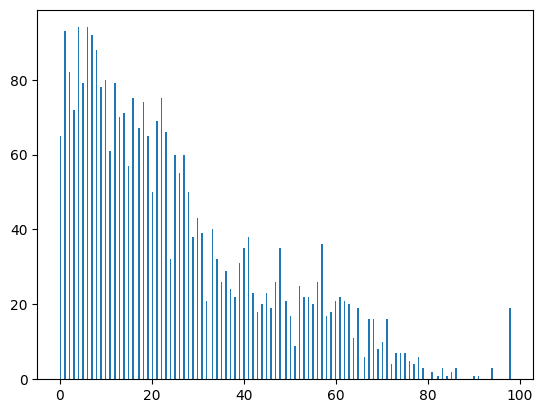

In [5]:
def histogram_traj_length(self, ax=None, **kwargs):
    import seaborn as sns

    id_to_sc_trajs = self.track_id_to_trajectory
    all_traj_lengths = np.array([_traj.get_timeframe_span_length() for _traj in id_to_sc_trajs.values()])
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    plt.hist(all_traj_lengths, bins=300, **kwargs)
    return ax
histogram_traj_length(sc_traj_collection)

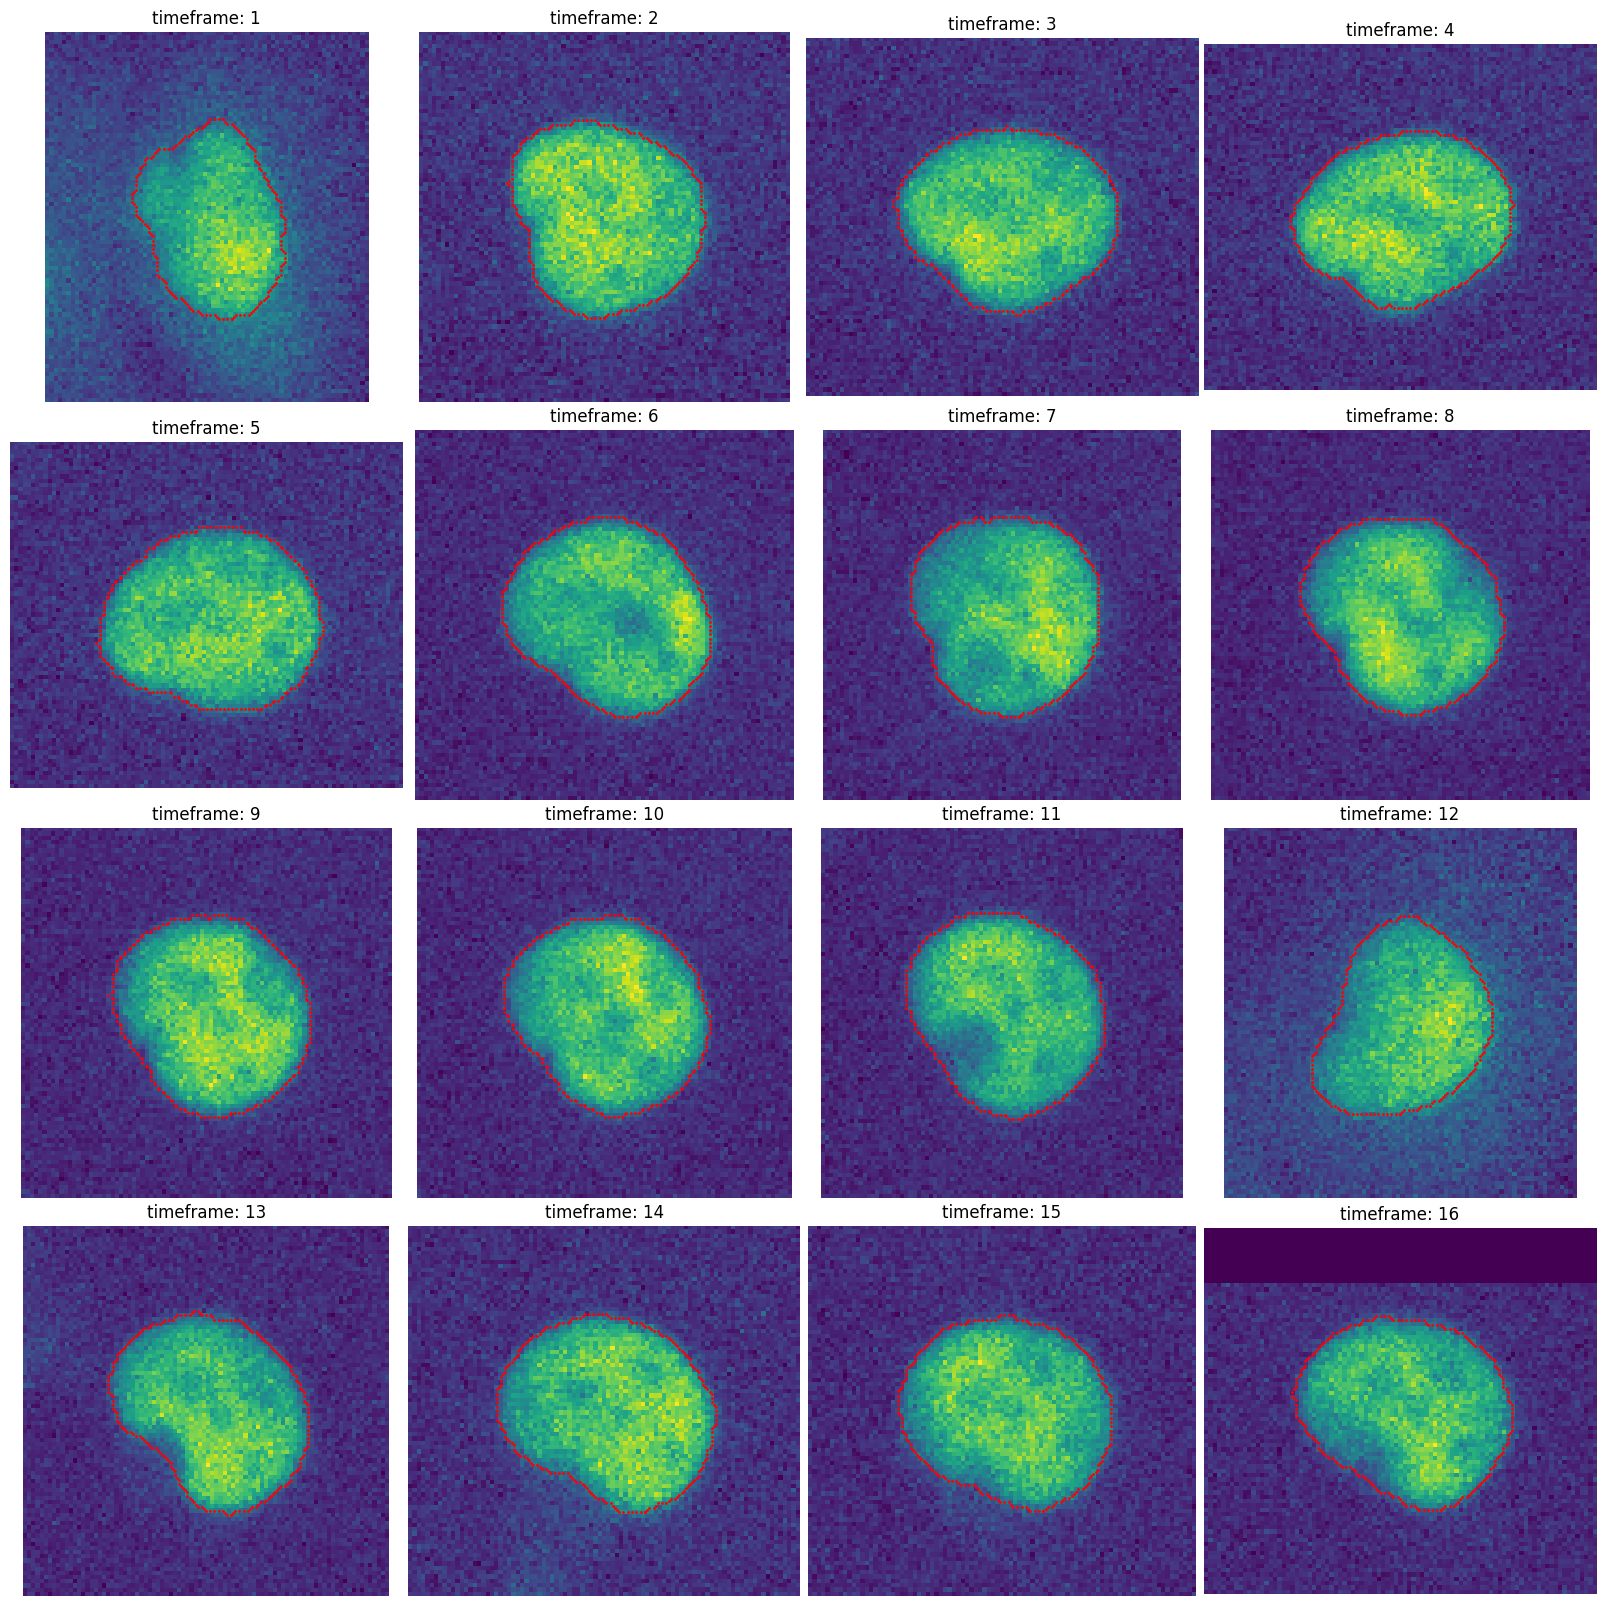

In [6]:
def show_trajectory_on_grid(
        trajectory: SingleCellTrajectory,
        nr=4,
        nc=4,
        start_timeframe=1,
        time_interval=1,
        bbox_padding=20,
    ):
        fig, axes = plt.subplots(nr, nc, figsize=(nc * 4, nr * 4))
        if nr == 1:
            axes = np.array([axes])
        span_range = trajectory.get_timeframe_span_range()
        traj_start, traj_end = span_range
        if start_timeframe < traj_start:
            print(
                "start timeframe larger than the first timeframe of the trajectory, replace start_timeframe with the first timeframe..."
            )
            start_timeframe = span_range[0]
        for r in range(nr):
            for c in range(nc):
                ax = axes[r, c]
                ax.axis("off")
                timeframe = start_timeframe + time_interval * (r * nc + c)
                if timeframe > traj_end:
                    print("timeframe: {timeframe} larger than the last timeframe of the trajectory, stopping...".format(timeframe=timeframe))
                    break
                if timeframe not in trajectory.timeframe_set:
                    print("timeframe: {timeframe} does not present in the trajectory, skipping...".format(timeframe=timeframe))
                    continue
                sc = trajectory.get_single_cell(timeframe)
                sc_img = sc.get_img_crop(padding=bbox_padding)
                ax.imshow(sc_img)
                contour_coords = sc.get_img_crop_contour_coords(padding=bbox_padding)
                ax.scatter(contour_coords[:, 1], contour_coords[:, 0], s=1, c="r")
                # trajectory_collection[timeframe].plot(axes[r, c])
                ax.set_title(f"timeframe: {timeframe}")
        fig.tight_layout(pad=0.5, h_pad=0.4, w_pad=0.4)

from livecell_tracker.core.visualizer import Visualizer

show_trajectory_on_grid(sc_traj_collection[29])

In [7]:
from livecell_tracker.track.movie import generate_single_trajectory_movie

for track_id, traj in sc_traj_collection:
    generate_single_trajectory_movie(traj, save_path=f"./notebook_results/wayne_data/track_movies/track_{track_id}.mp4")

saving to: ./notebook_results/wayne_data/track_movies/track_28.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_29.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_32.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_33.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_34.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_36.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_37.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_39.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_41.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_42.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_43.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_45.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_46.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_47.mp4...
saving to: ./noteboo

/home/ke/LiveCellTracker-dev/livecell_tracker/track/movie.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


saving to: ./notebook_results/wayne_data/track_movies/track_55.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_57.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_58.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_60.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_61.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_62.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_64.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_66.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_67.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_68.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_71.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_73.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_74.mp4...
saving to: ./notebook_results/wayne_data/track_movies/track_76.mp4...
saving to: ./noteboo

### Compute features

In [ ]:
from multiprocessing import Pool
# def compute_feature_helper(data):
#     idx, traj_id, traj = data
#     traj.compute_features("haralick", feature_extractors.compute_haralick_features)
#     traj.compute_features("skimage", feature_extractors.compute_skimage_regionprops)
# with Pool(8) as pool:
#     tasks = [[idx] + list(data) for idx, data in enumerate(list(iter(sc_traj_collection)))]
#     # p.map(tasks)
#     for _ in tqdm(pool.imap_unordered(compute_feature_helper, tasks), total=len(tasks)):
#         pass
for _, traj in tqdm(sc_traj_collection):
    traj.compute_features("haralick", feature_extractors.compute_haralick_features)
    traj.compute_features("skimage", feature_extractors.compute_skimage_regionprops)

In [ ]:
feature_table = sc_traj_collection.get_feature_table()

In [ ]:
feature_table.to_csv("./notebook_results/wayne_data/feature.csv")

In [ ]:
feature_table[:2]